In [4]:
import torch

from torchfem import Truss

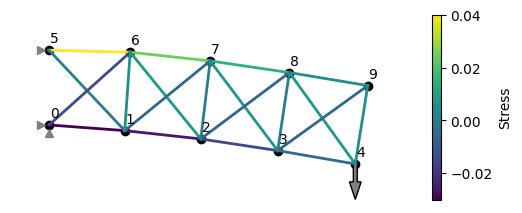

In [5]:
n1 = torch.linspace(0.0, 4.0, 5)
n2 = torch.linspace(0.0, 1.0, 2)
n1, n2 = torch.stack(torch.meshgrid(n1, n2, indexing="xy"))
nodes = torch.stack([n1.ravel(), n2.ravel()], dim=1)

elements = torch.tensor(
    [
        [0, 1],
        [1, 2],
        [2, 3],
        [3, 4],
        [5, 6],
        [6, 7],
        [7, 8],
        [8, 9],
        [1, 5],
        [0, 6],
        [2, 6],
        [1, 7],
        [3, 7],
        [2, 8],
        [4, 8],
        [3, 9],
        [1, 6],
        [2, 7],
        [3, 8],
        [4, 9],
    ]
)

# Create truss
truss = Truss(nodes, elements)

# Set boundary conditions
truss.forces[4, 1] = -0.01
truss.constraints[0, 0] = True
truss.constraints[0, 1] = True
truss.constraints[5, 0] = True

# Solve
u, f = truss.solve()

# Post-process
sigma = truss.compute_stress(u)

# Plot
truss.plot(u=u, sigma=sigma)

In [6]:
nodes = torch.tensor(
    [[-1.0, 0.0, 0.0], [1.0, 0.0, 0.0], [0.0, 1.0, 0.0], [0.0, 0.0, 1.0]]
)
elements = torch.tensor([[0, 3], [1, 3], [2, 3]])

# Create truss
truss3d = Truss(nodes, elements)

# Boundary conditions
truss3d.forces[3, 1] = -0.001
truss3d.constraints[0:3, :] = True

# Geometrical properties
truss3d.areas[:] = 0.05

# Solve
u, f = truss3d.solve()

# Post-process
sigma = truss3d.compute_stress(u)

# Plot
truss3d.plot(u=u, sigma=sigma)

Widget(value='<iframe src="http://localhost:62877/index.html?ui=P_0x158f68910_1&reconnect=auto" class="pyvista…